<a href="https://colab.research.google.com/github/bubbles42/predicting-item-sales-model/blob/main/predicting_item_sales_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Austin Weinland

In [65]:
# Import standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import joblib
pd.set_option('display.max_columns',100)
# Import modeling tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
# set the default output to pandas
from sklearn import set_config
set_config(transform_output='pandas')

## Customization Options
plt.style.use(('ggplot','seaborn-v0_8-notebook'))
sns.set_context(context='notebook', font_scale= 1.2)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.facecolor']='lightblue'
#plt.style.available

##Load and Inspect Data

In [66]:
fpath = '/content/drive/MyDrive/Coding Dojo - Data Science & Machine Learning/Machine Learning Fundamentals/Week 1/Data/Copy of sales_predictions_2023.csv'
df = pd.read_csv(fpath)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3000,Low Fat,0.0160,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.1380"
1,DRC01,5.9200,Regular,0.0193,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5000,Low Fat,0.0168,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.2700"
3,FDX07,19.2000,Regular,0.0000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.9300,Low Fat,0.0000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [67]:
df_copy = df.copy()

In [68]:
df_copy.duplicated().sum()

0

In [69]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [70]:
df_copy.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

##Univariate EDA Function

In [71]:
# Basic imports for functions
import matplotlib.pyplot as plt
import seaborn as sns

# UNIVARIATE PLOTTING FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

##Checking for inconsistencies and other possible issues

In [72]:
cat_cols = df_copy.select_dtypes(include='object').columns

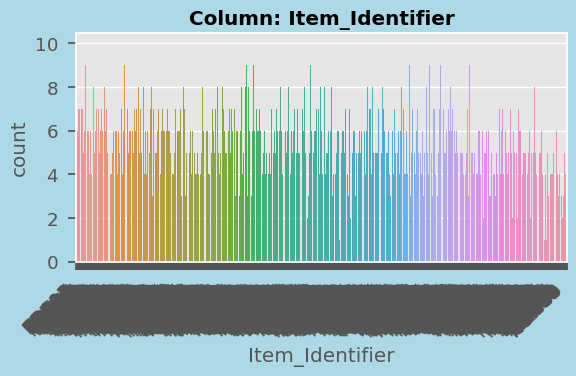

- NaN's Found: 0 (0.0%)
- Unique Values: 1559
- Most common value: 'FDW13' occurs 10 times (0.12%)
- Not constant or quasi-constant.
(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'Column: Item_Identifier'}, xlabel='Item_Identifier', ylabel='count'>)


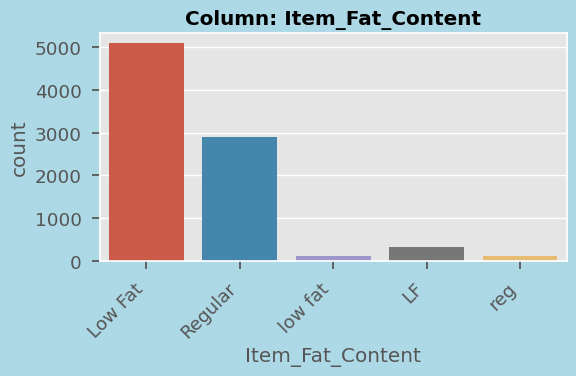

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'Low Fat' occurs 5089 times (59.71%)
- Not constant or quasi-constant.
(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'Column: Item_Fat_Content'}, xlabel='Item_Fat_Content', ylabel='count'>)


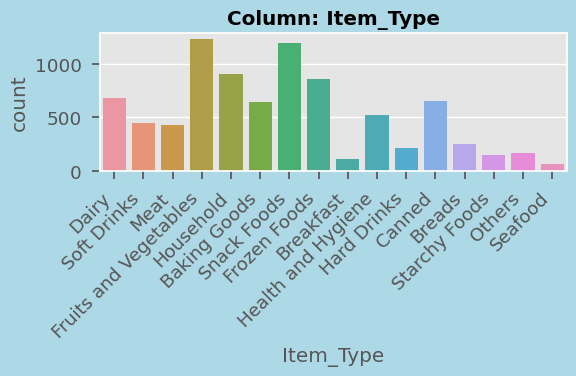

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.
(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'Column: Item_Type'}, xlabel='Item_Type', ylabel='count'>)


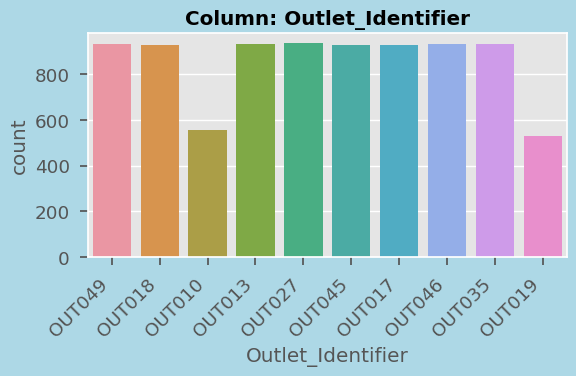

- NaN's Found: 0 (0.0%)
- Unique Values: 10
- Most common value: 'OUT027' occurs 935 times (10.97%)
- Not constant or quasi-constant.
(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'Column: Outlet_Identifier'}, xlabel='Outlet_Identifier', ylabel='count'>)


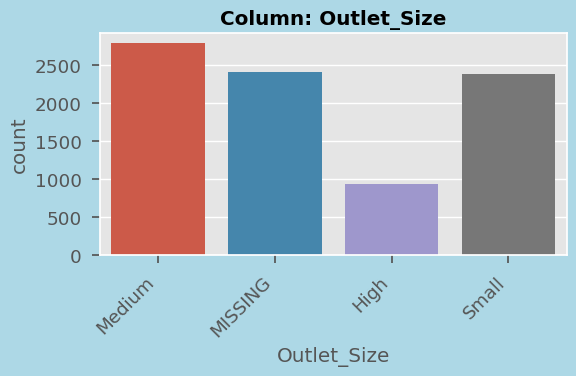

- NaN's Found: 2410 (28.28%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.
(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'Column: Outlet_Size'}, xlabel='Outlet_Size', ylabel='count'>)


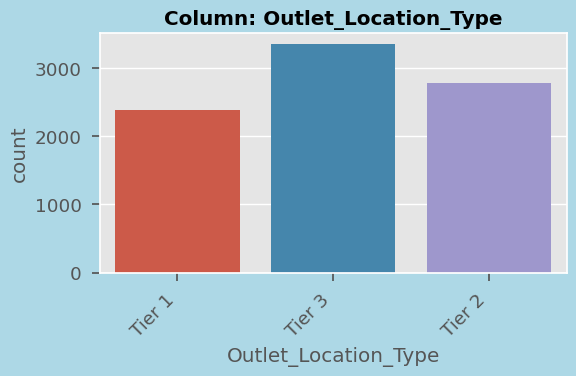

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.
(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'Column: Outlet_Location_Type'}, xlabel='Outlet_Location_Type', ylabel='count'>)


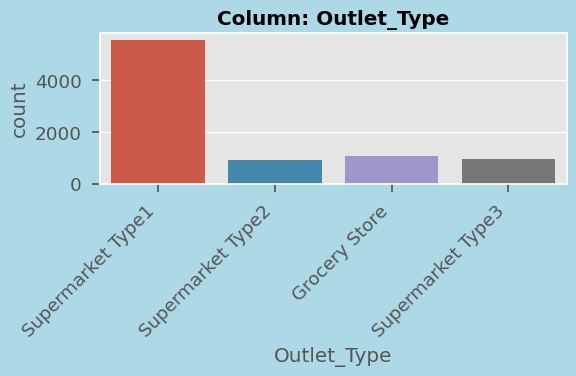

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.
(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'Column: Outlet_Type'}, xlabel='Outlet_Type', ylabel='count'>)


In [73]:
for c in cat_cols:
  print(explore_categorical(df_copy, c))

##Addressing issues

In [74]:
df_copy = df_copy.drop(columns='Item_Identifier')
df_copy.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.3000,Low Fat,0.0160,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.1380"
1,5.9200,Regular,0.0193,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.5000,Low Fat,0.0168,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.2700"
3,19.2000,Regular,0.0000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.9300,Low Fat,0.0000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [75]:
df_copy['Item_Fat_Content'] = df_copy['Item_Fat_Content'].replace({
                                                         'low fat':'Low Fat',
                                                         'LF':'Low Fat',
                                                         'reg':'Regular'
                                                         })
df_copy['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [76]:
df_copy.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,"7,060.0000","8,523.0000","8,523.0000","8,523.0000","8,523.0000"
mean,12.8576,0.0661,140.9928,"1,997.8319","2,181.2889"
std,4.6435,0.0516,62.2751,8.3718,"1,706.4996"
min,4.5550,0.0000,31.2900,"1,985.0000",33.2900
25%,8.7737,0.0270,93.8265,"1,987.0000",834.2474
50%,12.6000,0.0539,143.0128,"1,999.0000","1,794.3310"
75%,16.8500,0.0946,185.6437,"2,004.0000","3,101.2964"
max,21.3500,0.3284,266.8884,"2,009.0000","13,086.9648"


##Splitting Data

In [77]:
target = 'Item_Outlet_Sales'
X = df_copy.drop(columns=target)
y = df_copy[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##Preprocessing Data

In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                5285 non-null   float64
 1   Item_Fat_Content           6392 non-null   object 
 2   Item_Visibility            6392 non-null   float64
 3   Item_Type                  6392 non-null   object 
 4   Item_MRP                   6392 non-null   float64
 5   Outlet_Identifier          6392 non-null   object 
 6   Outlet_Establishment_Year  6392 non-null   int64  
 7   Outlet_Size                4580 non-null   object 
 8   Outlet_Location_Type       6392 non-null   object 
 9   Outlet_Type                6392 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 549.3+ KB


In [79]:
X_train['Item_Fat_Content'].value_counts()

Low Fat    4129
Regular    2263
Name: Item_Fat_Content, dtype: int64

In [80]:
X_train['Outlet_Size'].value_counts()

Medium    2103
Small     1788
High       689
Name: Outlet_Size, dtype: int64

In [81]:
num_cols = X_train.select_dtypes(include='number').columns

mean_impute = SimpleImputer(strategy='mean')
num_scale = StandardScaler()

num_pipe = make_pipeline(mean_impute, num_scale)
num_tup = ('numeric', num_pipe, num_cols)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [82]:
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')

In [83]:
ord_cols = ['Outlet_Size']

type_order = ['Missing','Small', 'Medium', 'High']
ord_type_order = [type_order]

ord_impte = SimpleImputer(strategy='constant', fill_value='Missing')
ord_encode = OrdinalEncoder(categories=ord_type_order)
ord_scale = StandardScaler()

ord_pipe = make_pipeline(ord_impte, ord_encode, ord_scale)
ord_tup = ('ordinal', ord_pipe, ord_cols)
ord_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Missing', 'Small', 'Medium',
                                             'High']])),
                ('standardscaler', StandardScaler())])

In [84]:
cat_cols = X_train.select_dtypes(include='object').drop(columns=ord_cols).columns
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [85]:
nom_encoder = OneHotEncoder(sparse_output=False, drop='first')
nom_pipe = make_pipeline(nom_encoder)
nom_tup = ('nominal', nom_pipe, cat_cols)
nom_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(drop='first', sparse_output=False))])

> I will use drop first in the one hot encoding to help make more sensible numbers for our coeffs.

##Column Transform

In [86]:
col_trans = ColumnTransformer([num_tup, ord_tup, nom_tup],
                              verbose_feature_names_out=False)
col_trans

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  Ordi...er(categories=[['Missing',
                                                                              'Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('nominal',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

##Regression Evaluation Functions

In [87]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

# results = evaluate_regression(lin_reg, X_train_proc, y_train, X_test_proc,
                                # y_test, output_frame=True, verbose=False)
# results

#Instantiate Linear Model

In [88]:
linreg = LinearRegression()

linreg_pipe = make_pipeline(col_trans, linreg)

linreg_pipe.fit(X_train, y_train)
evaluate_regression(linreg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.129
- MSE = 1,297,558.136
- RMSE = 1,139.104
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.120
- MSE = 1,194,349.715
- RMSE = 1,092.863
- R^2 = 0.567


This model appears to be underfit as it is performing poorly on both train and test data

#Random Forest Model

In [89]:
ran_for = RandomForestRegressor(random_state=42)

ran_pipe = make_pipeline(col_trans, ran_for)
ran_pipe.fit(X_train, y_train)
evaluate_regression(ran_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 296.688
- MSE = 183,957.835
- RMSE = 428.903
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 775.765
- MSE = 1,239,180.553
- RMSE = 1,113.185
- R^2 = 0.551


Based on the r2 scores I would say this base model appears to be overfitting as it performs well on the training but not the test data

#Tune Random Forest w/ GridSearchCV

In [90]:
ran_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Missing',
                                                                   strategy='constant')),
                                                    ('ordinalencoder',
                                                     Ordi...er(categories=[['Missing',
       

In [91]:
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

In [92]:
gridsearch = GridSearchCV(ran_pipe, params, n_jobs=-1, cv = 3, verbose=1)
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(...
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 None],
                         'randomforestregressor__min_samples_leaf': [2, 3, 4],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200],
                         'randomforestregressor__oob_score': [True, False]},
             verbose=1)

In [93]:
gridsearch.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__oob_score': True}

In [94]:
bestran = gridsearch.best_estimator_
evaluate_regression(bestran, X_train, y_train, X_test, y_test, output_frame=True)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 642.897
- MSE = 841,935.942
- RMSE = 917.571
- R^2 = 0.716

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 737.618
- MSE = 1,122,368.133
- RMSE = 1,059.419
- R^2 = 0.593


,MAE,MSE,RMSE,R^2
Training Data,642.8970,"841,935.9420",917.5710,0.7160
Test Data,737.6180,"1,122,368.1330","1,059.4190",0.5930


The tuned model seems to have not overfit as much as the non tuned model. The performance on train data did decline, while the testing data saw an increast in performance.

#Evaluation of Models

I would recommend the Random Forest model, as it seems to be improving with the fine tuning, and started off at a better performace level than the linear regression model.

Looking at the r2 score we can see how much of the error the model is able to explain. In otherwords, the higher the number the better the model can explain the errors in predictions vs true values.

We can see that as we start to fine tune the Random Forest Model we are starting to see an improvement in the performance, and the model is becoming less overfit. Meaning it is not training on the train data so well that it can not predict new data well.

The second measurement to look at here would be out MAE score, which is our Mean Average Error. This tells us by how much on average the model is off on it's predictions. We can see that from the untuned to tuned model we do see a slight improvment on the test data, while we see a significant dip in performance on training data. This is showing that the model is less over fit than it was before training, and is what can explain the improved performance of the testing data.

#Model Insights

##Linear Regression

In [95]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

lincoeffs = get_coeffs_linreg(linreg)
pd.set_option('display.float_format', lambda x: f"{x:,.4f}")
lincoeffs

Outlet_Identifier_OUT019           -640.1429
Outlet_Identifier_OUT013           -351.7264
Outlet_Location_Type_Tier 3        -259.3255
Outlet_Identifier_OUT035           -157.2435
Outlet_Identifier_OUT049           -155.5404
Item_Type_Dairy                    -106.3350
Item_Type_Soft Drinks               -39.4857
Item_Type_Breads                    -28.6483
Item_Type_Others                    -26.8137
Item_Type_Snack Foods               -21.9324
Item_Visibility                     -21.6465
Item_Type_Meat                      -11.8649
Item_Weight                          -8.1868
Item_Type_Frozen Foods               -1.7706
Item_Type_Household                   5.5097
Item_Type_Hard Drinks                13.8949
Item_Type_Health and Hygiene         27.0254
Item_Type_Canned                     27.5162
Item_Type_Starchy Foods              42.0889
Item_Type_Breakfast                  45.3611
Item_Type_Fruits and Vegetables      45.7540
Outlet_Identifier_OUT018             46.2561
Outlet_Typ

In [96]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5),
                intercept=False, intercept_name="intercept",
                annotate=False, ha='left', va='center', size=12,
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

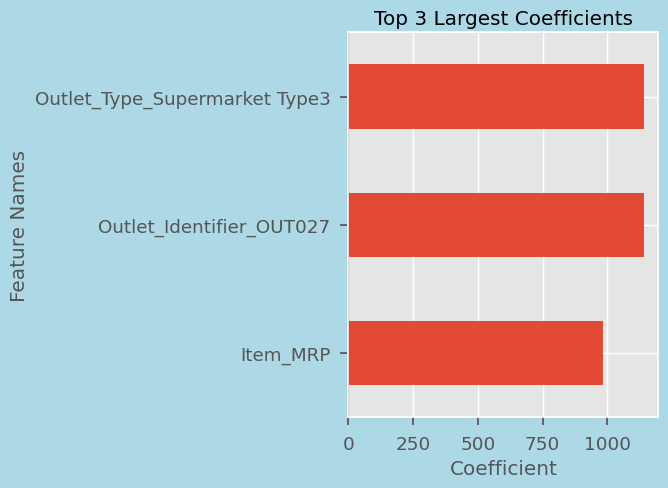

In [103]:
plot_coeffs(lincoeffs, top_n=3);

> Out top 3 coefficients are:

- Outlet_Type_Supermarket Type3
- Outlet_Identifier_OUT027
- Item_MRP

All of these are showing stong positive coefficients, meaning they have a positive correlation with our target.

##Random Forest

In [98]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax

In [104]:
feature_name = col_trans.get_feature_names_out()

X_train_tf = pd.DataFrame(col_trans.transform(X_train),
                          columns=feature_name, index=X_train.index)

X_test_tf = pd.DataFrame(col_trans.transform(X_test),
                         columns=feature_name, index=X_test.index)

In [ ]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

feature_names = col_trans.get_feature_names_out()
importances = pd.Series(ran_for.feature_importances_, index=feature_names)
r = permutation_importance(ran_for, X_test_tf, y_test, random_state=42)
permutation = pd.Series(r['importances_mean'], index=X_test_tf.columns,
                        name='permutation importance')
colordict = get_color_dict(importances, top_n=5)

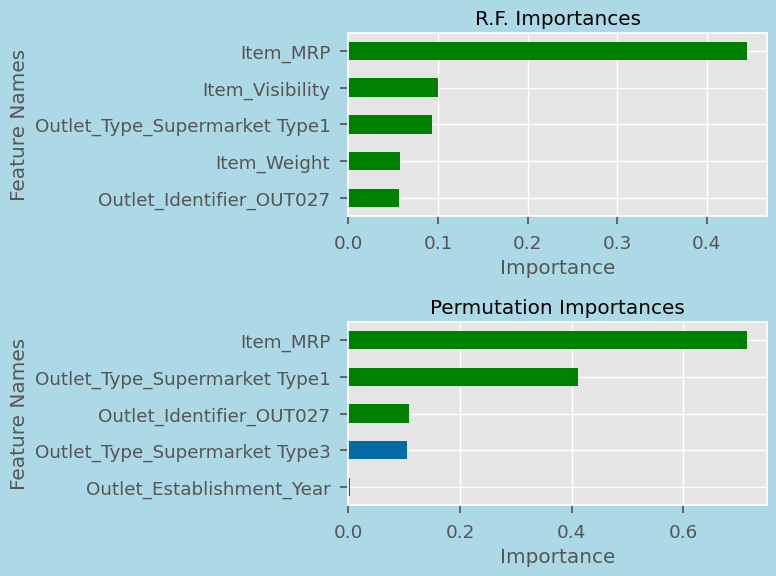

In [121]:
fig, axes = plt.subplots(nrows=2, figsize=(20,12))
n = 5
plot_importance_color_ax(importances, top_n=n, ax=axes[0],
                          color_dict= colordict)
plot_importance_color_ax(permutation, top_n=n, ax=axes[1],
                          color_dict=colordict)
axes[0].set(title='R.F. Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout();